In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtl
mtl.style.use("ggplot")
import pymc as pm
import scipy.stats as stats
import scipy.optimize as sop
import arviz as az
figsize(12.5, 6)
from scipy.optimize import fmin

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


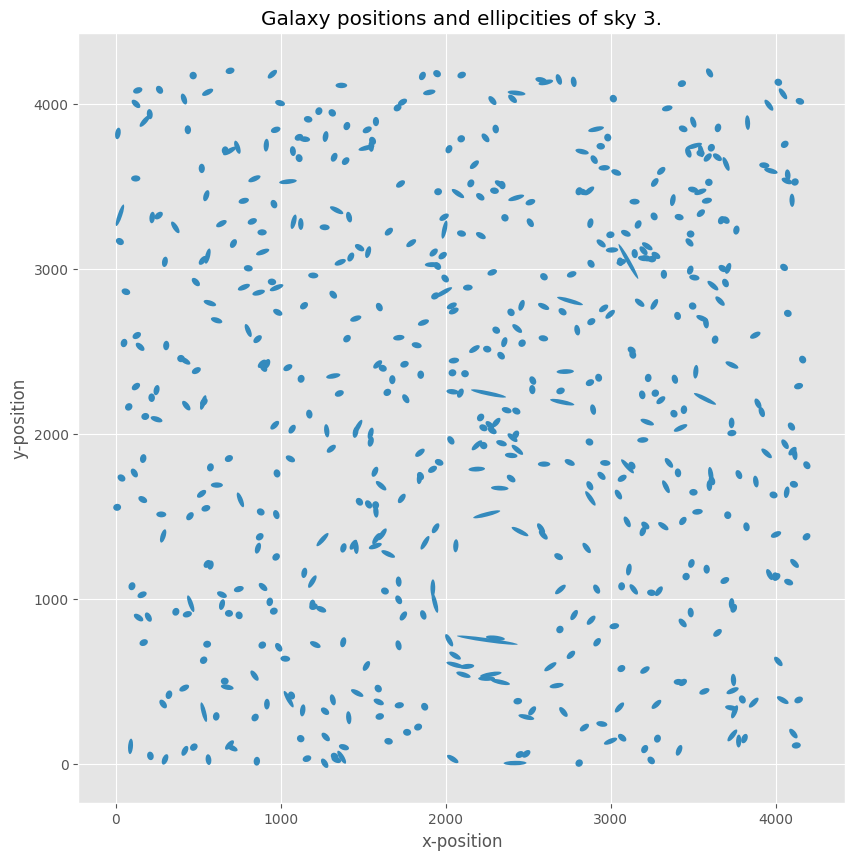

In [11]:
from draw_sky2 import draw_sky

n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

In [12]:
import pymc as pm
import pytensor.tensor as pt

def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2)).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    # T.maximum() provides our element-wise maximum as in NumPy, but instead for theano tensors
    return pt.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2*pt.arctan(delta[:,1]/delta[:,0]))
    return pt.stack([-pt.cos(t), -pt.sin(t)], axis=1)


with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large /\
            f_distance(pt.as_tensor(data[:,:2]), halo_position, 240)*\
            tangential_distance(pt.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

In [13]:
with model:
    # mu, sds, elbo = pm.variational.advi(n=50000)
    # step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
    # trace = pm.sample(5000, step=step, start=mu)
    
    trace = pm.sample(5000, init='advi', n_init=50000,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 27000
Interrupted at 26,999 [53%]: Average Loss = -106.67
Sequential sampling (1 chains in 1 job)
NUTS: [mass_large, halo_position]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


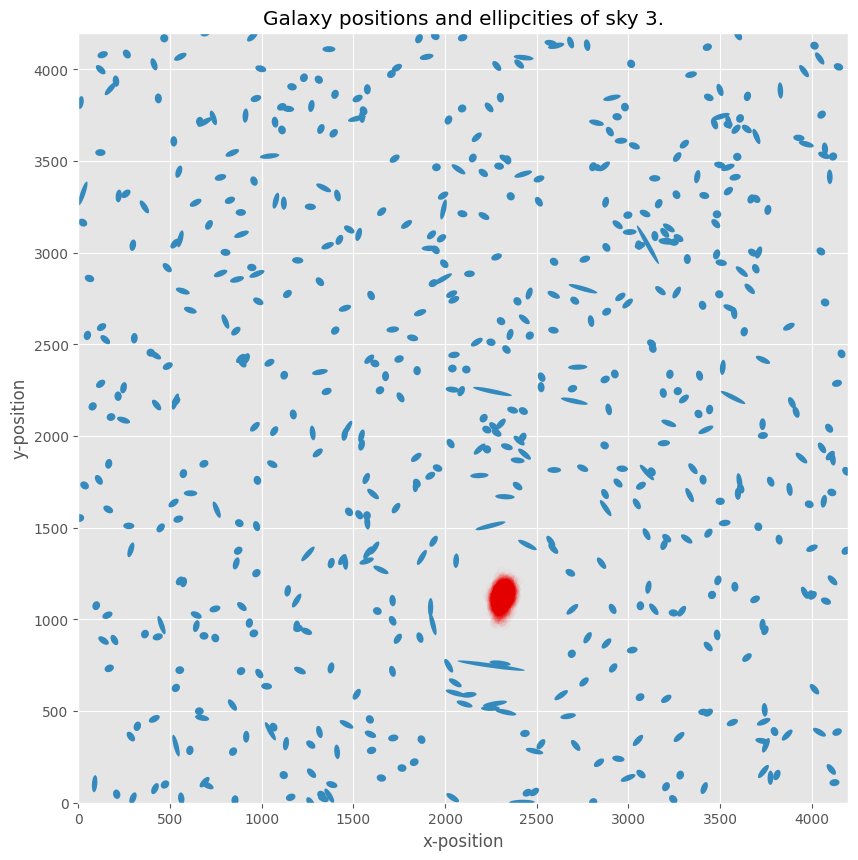

In [14]:
# t = trace["halo_position"].reshape(5000,2)
t = trace.posterior.halo_position.data.reshape(5000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [15]:
halo_data = np.genfromtxt("data/Training_halos.csv", 
                          delimiter = ",",
                          usecols = [1, 2,3, 4,5,6,7,8,9],
                          skip_header = 1)
print(halo_data[n_sky])

[1.00000e+00 1.40861e+03 1.68586e+03 1.40861e+03 1.68586e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


True halo location: 1408.61 1685.86


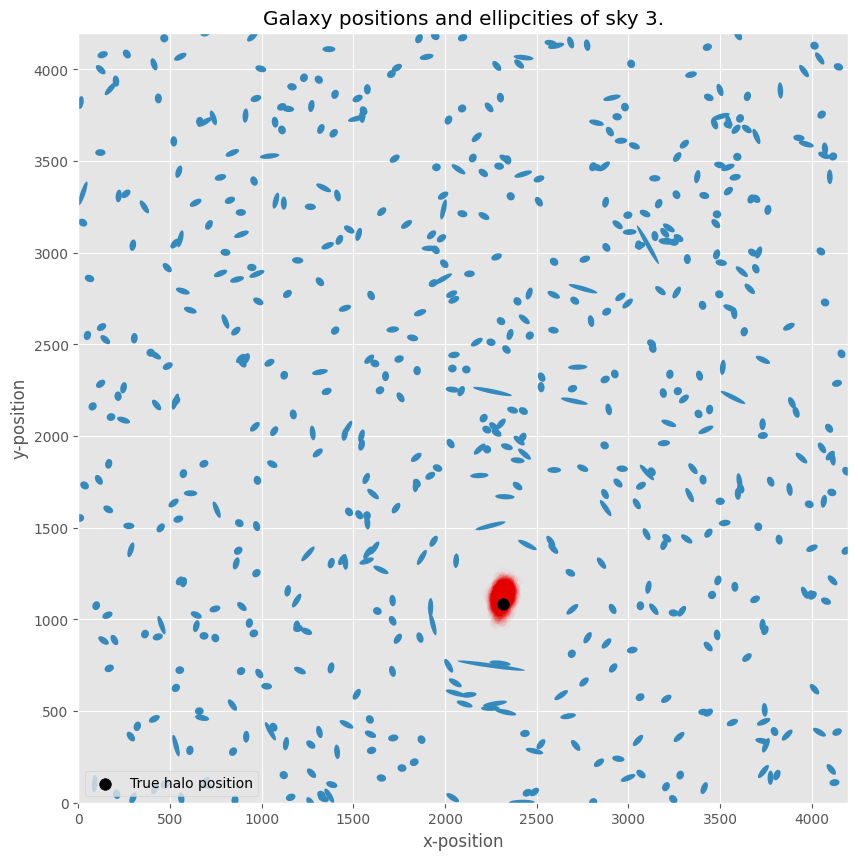

In [16]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], 
            label = "True halo position",
            c = "k", s = 70)
plt.legend(scatterpoints = 1, loc = "lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

In [17]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)

[[2312.11120696 1127.04809409]]


In [18]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky-1]

nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 45.247078723749006
Your average angular vector is 1.0
Your score for the training data is 1.0452470787237491
Using a random location: [[ 991 1021]]
Your average distance in pixels you are away from the true halo is 1326.1813416346954
Your average angular vector is 1.0
Your score for the training data is 2.3261813416346957


2.3261813416346957

In [19]:
def halo_posteriors(n_halos_in_sky, galaxy_data,samples = 5e5, burn_in = 500):
    #set the size of the halo's mass
    with pm.Model() as model:
        mass_large = pm.Uniform("mass_large", 40, 180)
        
        mass_small_1 = 20
        mass_small_2 = 20
    
        masses = np.array([mass_large,mass_small_1, mass_small_2], dtype=object)
    
        #set the initial prior positions of the halos, it's a 2-d Uniform dist.
        halo_positions = pm.Uniform("halo_positions", 0, 4200, shape=(n_halos_in_sky,2)) #notice this size
    
        fdist_constants = np.array([240, 70, 70])
        
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += masses[i]/f_distance(data[:,:2], halo_positions[i, :], fdist_constants[i])*\
                tangential_distance(data[:,:2], halo_positions[i, :])
        
        mean = pm.Deterministic("mean", _sum)
               
        ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])
    
        # mu, sds, elbo = pm.variational.advi(n=50000)
        # step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
        trace = pm.sample(samples, init='advi', n_init=50000,tune=burn_in,chains=4)
        
    # burned_trace = trace[burn_in:]
    return trace.posterior.halo_positions.data

In [20]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])

In [21]:
#there are 3 halos in this file. 
samples = 5000
traces = halo_posteriors(3, data, samples = samples, burn_in=500)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = -121.3
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mass_large, halo_positions]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 1392 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


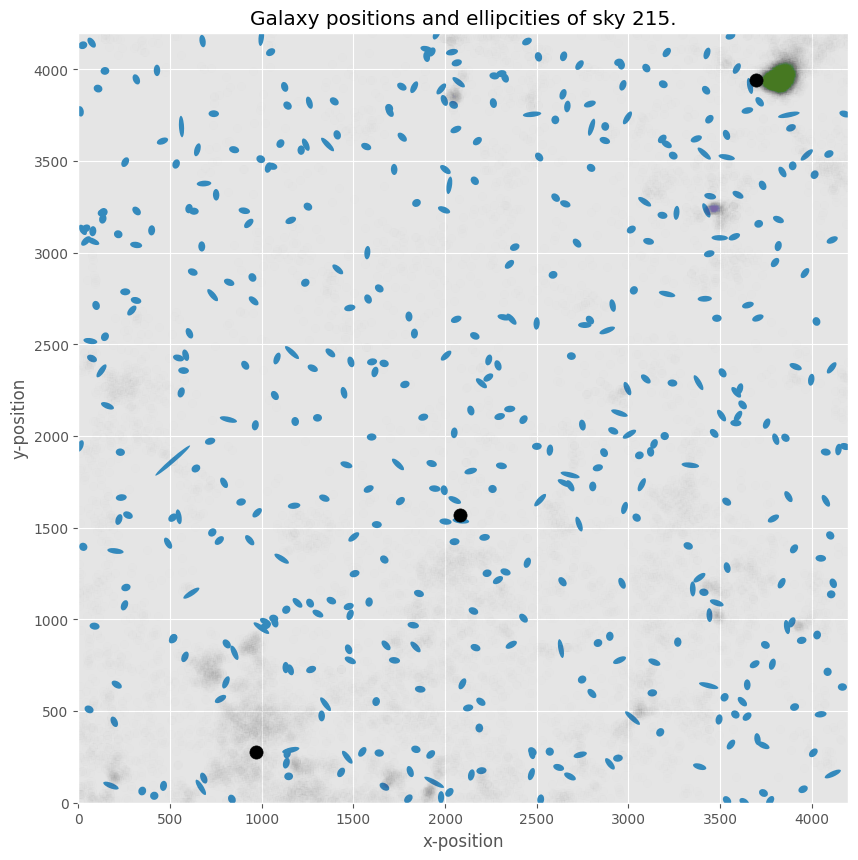

In [22]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces[0].shape[1]):
    plt.scatter(traces[0][:, i, 0],  traces[0][:, i, 1], c = colors[i], alpha = 0.002)
    
    
for i in range(traces.T.shape[1]):
    plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
            label = "True halo position", c = "k", s = 90)
    
#plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

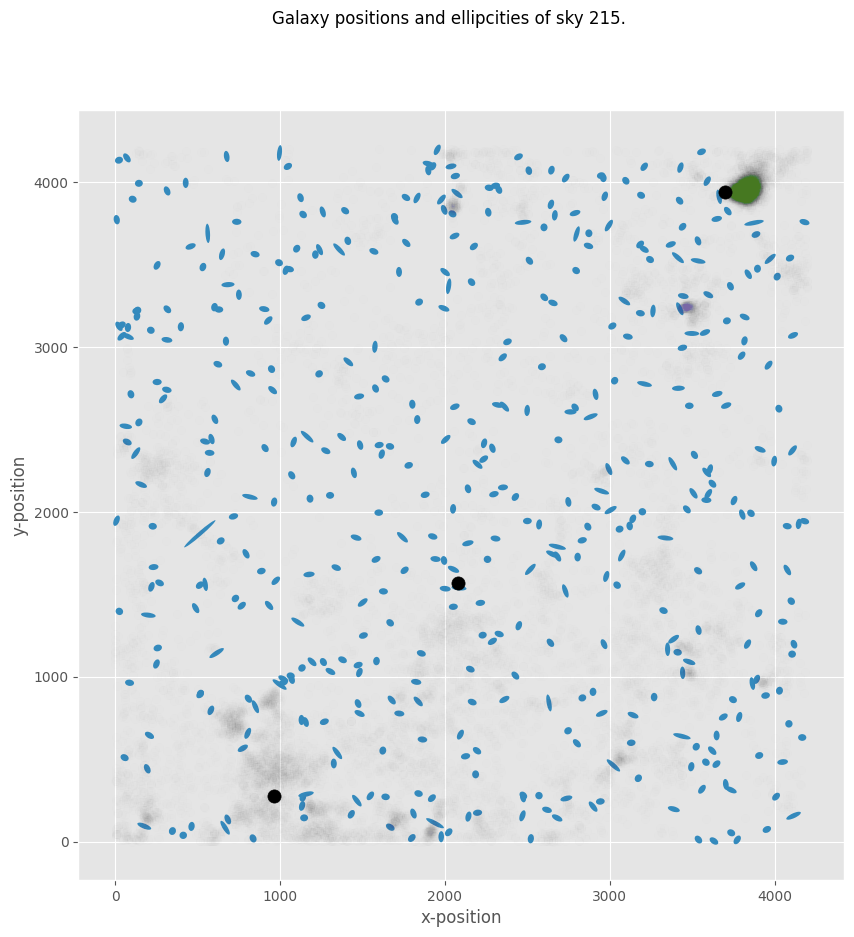

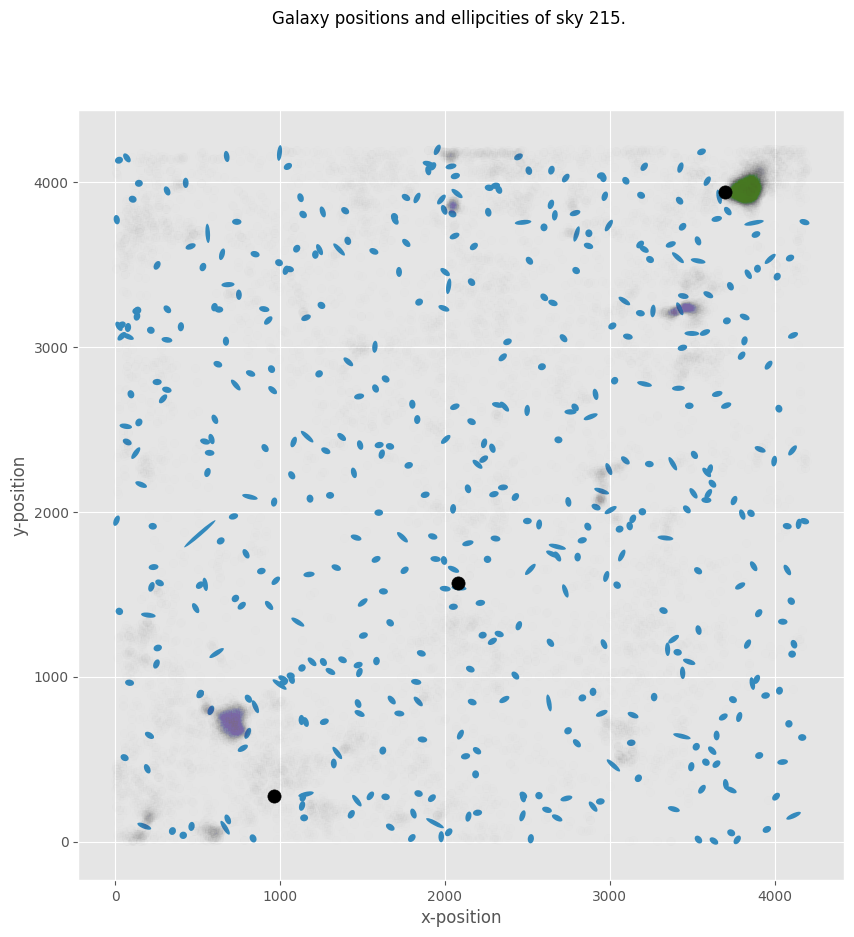

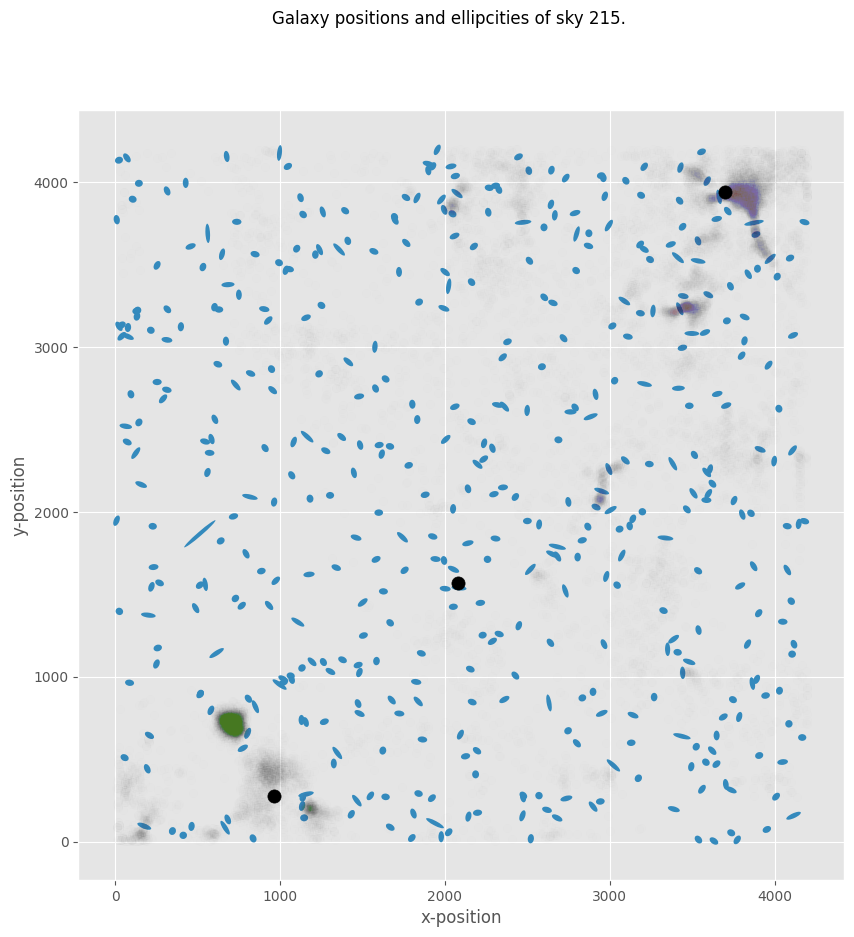

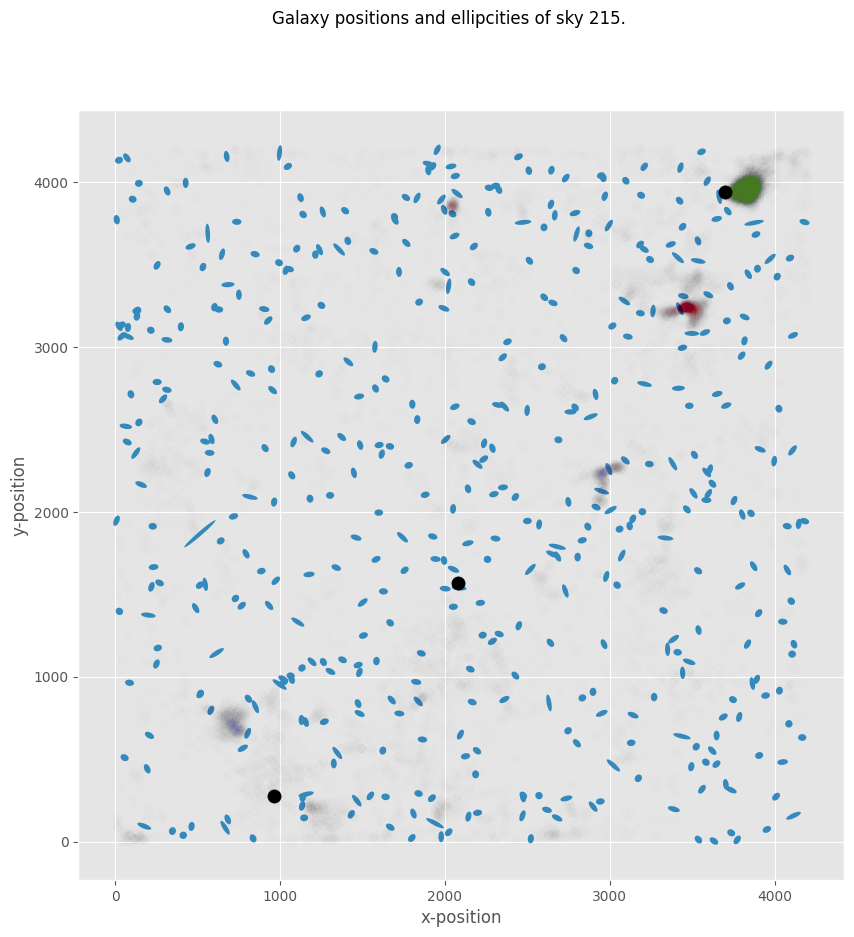

In [23]:
for pt in range(traces.shape[0]):
    fig = draw_sky(data)

    colors = ["#467821", "#A60628", "#7A68A6"]


    for i in range(traces[1].shape[1]):
            plt.scatter(traces[pt][:, i, 0],  traces[pt][:, i, 1], c = colors[i], alpha = 0.002)


    for i in range(traces.T.shape[1]):
        plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
                label = "True halo position", c = "k", s = 90)

    #plt.legend(scatterpoints = 1)
    # ax[0].xlim(0, 4200)
    # ax[0].ylim(0, 4200)
    plt.suptitle("Galaxy positions and ellipcities of sky %d." % n_sky)
    plt.xlabel("x-position")
    plt.ylabel("y-position")

In [24]:
_halo_data = halo_data[n_sky-1]
print(traces.shape)

for pt in range(traces.shape[0]): 
    print(f"Independent chains: {pt}")
    mean_posterior = traces[pt].mean(axis=0).reshape(1,6)
    print(mean_posterior)


    nhalo_all =  _halo_data[0].reshape(1,1)
    x_true_all = _halo_data[3].reshape(1,1)
    y_true_all = _halo_data[4].reshape(1,1)
    x_ref_all = _halo_data[1].reshape(1,1)
    y_ref_all = _halo_data[2].reshape(1,1)
    sky_prediction = mean_posterior


    print("Using the mean:")
    main_score([1], x_true_all, y_true_all, \
                x_ref_all, y_ref_all, sky_prediction)

    #what's a bad score?
    random_guess = np.random.randint(0, 4200, size=(1,2))
    print("Using a random location:", random_guess)
    main_score([1], x_true_all, y_true_all, \
                x_ref_all, y_ref_all, random_guess)

(4, 5000, 3, 2)
Independent chains: 0
[[3827.38211455 3963.35604255 1664.02651227  684.81366593 2168.84010795
  1884.91923706]]
Using the mean:
Your average distance in pixels you are away from the true halo is 132.66739408236324
Your average angular vector is 1.0
Your score for the training data is 1.1326673940823633
Using a random location: [[3888 2133]]
Your average distance in pixels you are away from the true halo is 1819.1439675022978
Your average angular vector is 1.0
Your score for the training data is 2.819143967502298
Independent chains: 1
[[3833.34089853 3964.62693192 1771.70150711 1720.10976885 1741.69899081
  2344.09208865]]
Using the mean:
Your average distance in pixels you are away from the true halo is 138.75329672319575
Your average angular vector is 1.0
Your score for the training data is 1.1387532967231957
Using a random location: [[1234 1917]]
Your average distance in pixels you are away from the true halo is 3188.1589129935164
Your average angular vector is 1.0
Yo

In [25]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: '../styles/custom.css'